正在按'学科门类'聚合文本...
数据聚合完成。共找到 25 个学科门类文档。
正在计算 TF-IDF 矩阵...
将使用以下自定义停用词: ['研究', '基于', '影响', '机制', '路径', '策略', '模式', '对策', '探析', '视域', '赋能', '建构', '实证', '问题', '机理']
TF-IDF 计算完成。
正在生成 '管理学' 关键词图表...
图表已成功保存为: management_top20_keywords_gradient.png (位于 /kaggle/working/ 目录)
正在显示图表: 管理学 TF-IDF 关键词 Top 20


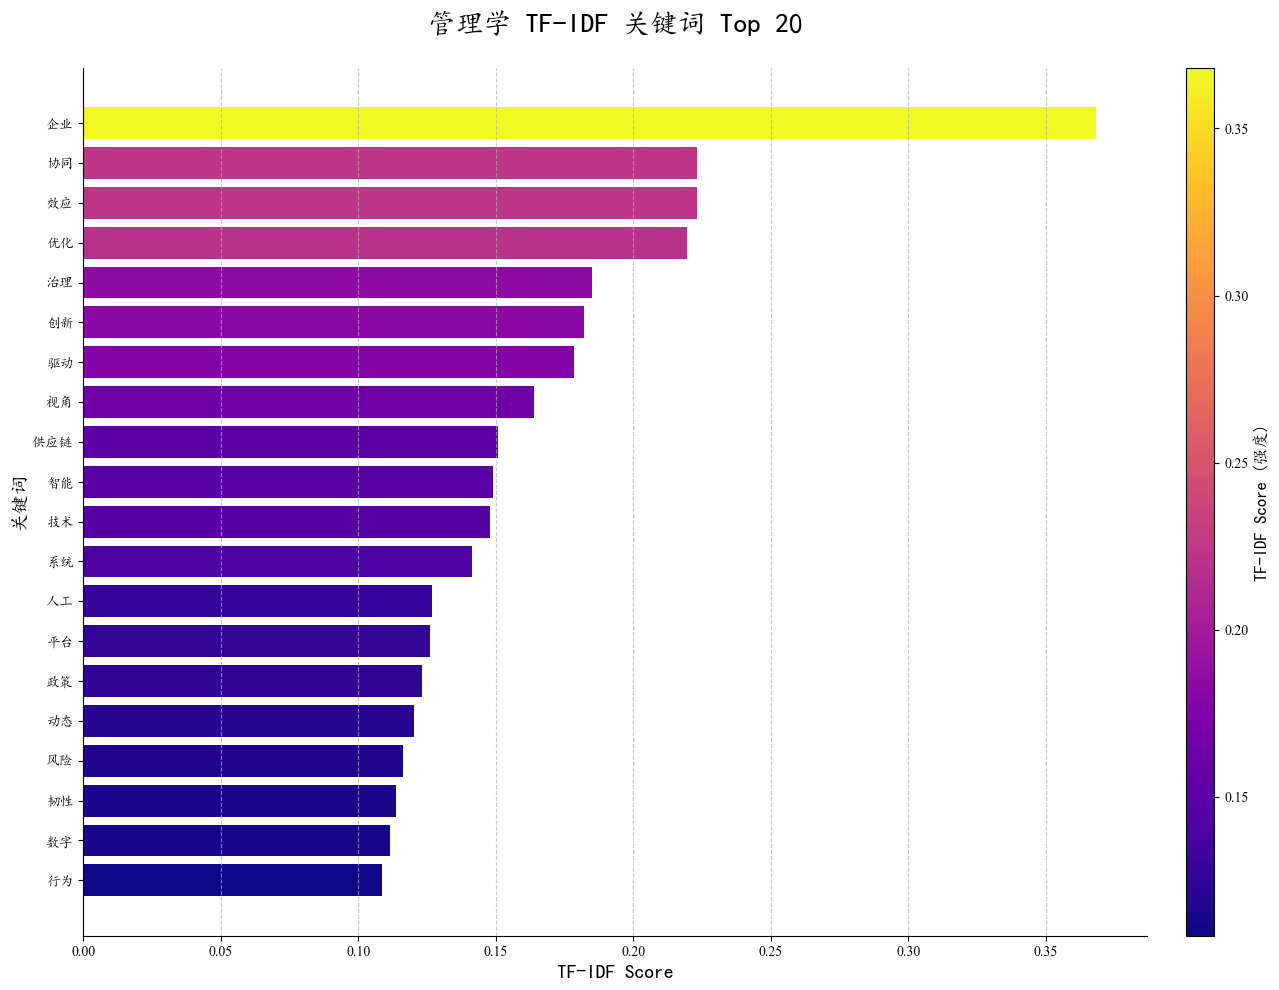

    word     tfidf
95    企业  0.368189
224   协同  0.223181
496   效应  0.223076
97    优化  0.219618
605   治理  0.184822
195   创新  0.182089
992   驱动  0.178295
823   视角  0.163898
122  供应链  0.150900
553   智能  0.149058
452   技术  0.147947
722   系统  0.141223
77    人工  0.126796
386   平台  0.126092
494   政策  0.122920
208   动态  0.120168
989   风险  0.116025
978   韧性  0.113814
510   数字  0.111590
798   行为  0.108491
正在生成 '交叉学科/综合研究' 关键词图表...
图表已成功保存为: interdisciplinary_top20_keywords_gradient.png (位于 /kaggle/working/ 目录)
正在显示图表: 交叉学科/综合研究 TF-IDF 关键词 Top 20


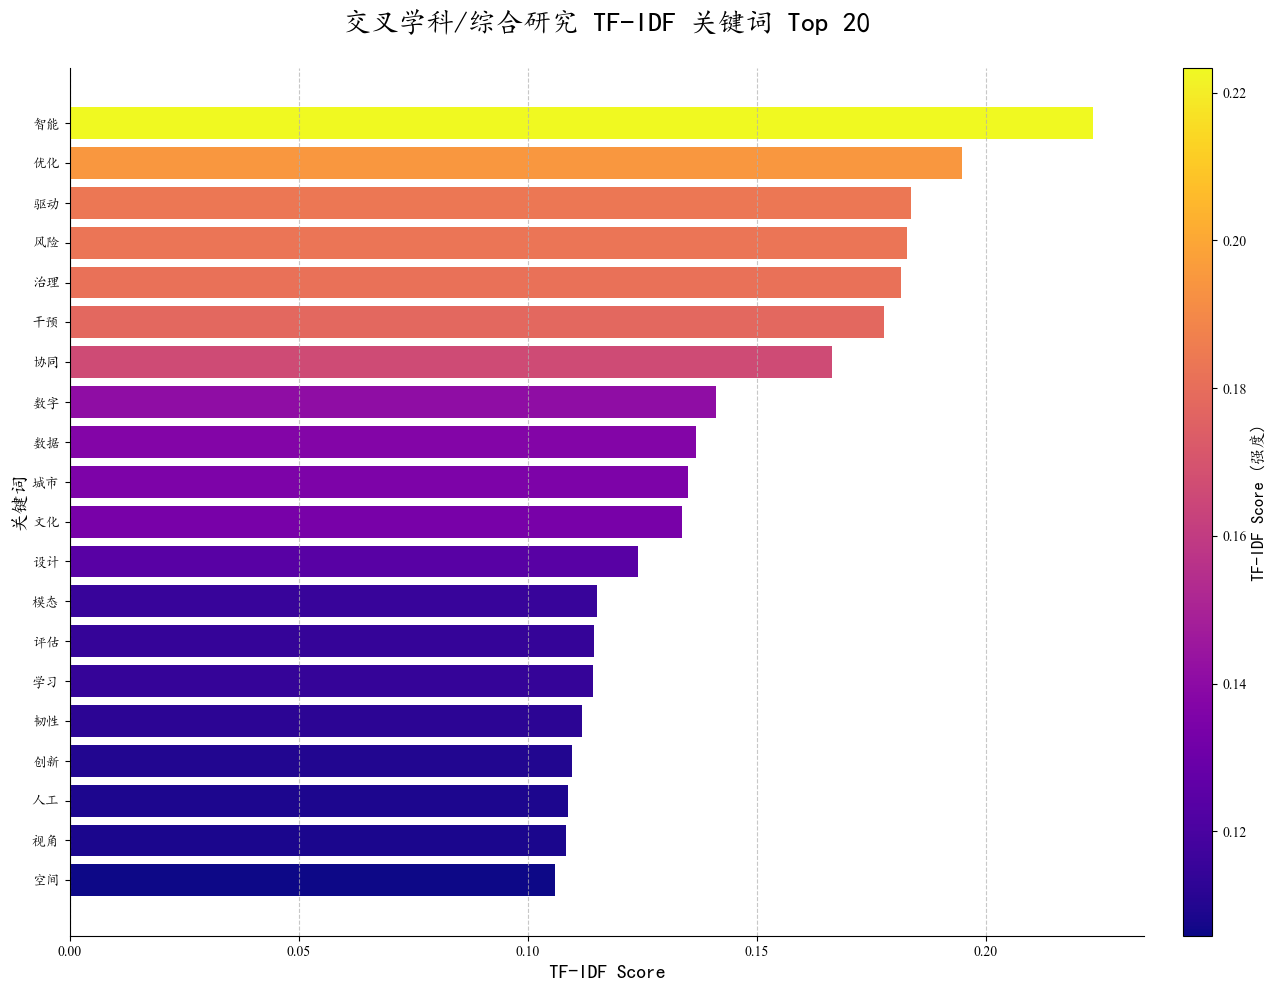

    word     tfidf
553   智能  0.223384
97    优化  0.194700
992   驱动  0.183729
989   风险  0.182719
605   治理  0.181497
385   干预  0.177710
224   协同  0.166373
510   数字  0.141165
513   数据  0.136659
295   城市  0.134891
519   文化  0.133602
843   设计  0.123962
585   模态  0.115183
846   评估  0.114571
334   学习  0.114165
978   韧性  0.111892
195   创新  0.109689
77    人工  0.108843
823   视角  0.108394
708   空间  0.105874
所有任务完成。


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
import numpy as np
import sys
import os

# --- 1. 设置字体和文件路径 (Kaggle路径) ---
# 定义文件所在的目录
input_dir = '/kaggle/input/fundings/'

# 定义字体文件路径
font_path_chinese = os.path.join(input_dir, 'simkai.ttf')
font_path_english = os.path.join(input_dir, 'times.ttf')

# 检查字体文件是否存在
if not os.path.exists(font_path_chinese):
    print(f"警告: 字体文件 '{font_path_chinese}' 未找到。中文可能无法正确显示。")
    ch_font = fm.FontProperties()
else:
    ch_font = fm.FontProperties(fname=font_path_chinese)
    fm.fontManager.addfont(font_path_chinese)

if not os.path.exists(font_path_english):
    print(f"警告: 字体文件 '{font_path_english}' 未找到。非中文字符可能无法使用指定字体。")
    en_font = fm.FontProperties()
else:
    en_font = fm.FontProperties(fname=font_path_english)
    fm.fontManager.addfont(font_path_english)

plt.rcParams['axes.unicode_minus'] = False 

# --- 2. 加载和准备数据 (Kaggle路径) ---
data_file = os.path.join(input_dir, '2025-jiaoyubu-fenci.csv')
try:
    df = pd.read_csv(data_file)
except FileNotFoundError:
    print(f"错误: 数据文件 '{data_file}' 未找到。请确保文件位于指定的Kaggle输入目录中。")
    sys.exit()
except Exception as e:
    print(f"读取CSV文件时出错: {e}")
    sys.exit()

df['项目名称分词'] = df['项目名称分词'].fillna('')

# --- 3. 将每个学科门类的项目合并为一个文档 ---
print("正在按'学科门类'聚合文本...")
if '学科门类' not in df.columns or '项目名称分词' not in df.columns:
    print("错误: CSV文件缺少 '学科门类' 或 '项目名称分词' 列。")
    sys.exit()
    
corpus = df.groupby('学科门类')['项目名称分词'].apply(' '.join)

target_disciplines = ['管理学', '交叉学科/综合研究']
if not all(d in corpus.index for d in target_disciplines):
    print(f"错误: 目标学科 '管理学' 或 '交叉学科/综合研究' 未在数据中找到。")
    print(f"可用的学科门类有: {corpus.index.tolist()}")
    sys.exit()

print(f"数据聚合完成。共找到 {len(corpus)} 个学科门类文档。")

# --- 4. 计算 TF-IDF (微调：添加停用词) ---
print("正在计算 TF-IDF 矩阵...")

# 微调：定义人文社科领域的常见停用词，根据您的要求加入“研究”
# 您可以根据需要向这个列表中添加更多词
my_stop_words = [
    '研究', '基于', '影响', '机制', '路径', '策略', '模式', 
    '对策', '探析', '视域', '赋能', '建构', '实证', '问题',
    '机理'
]

print(f"将使用以下自定义停用词: {my_stop_words}")

vectorizer = TfidfVectorizer(
    max_features=1000, 
    stop_words=my_stop_words
) 
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
print("TF-IDF 计算完成。")

# --- 5. 提取关键词的辅助函数 (无变化) ---
def get_top_keywords(discipline_name, corpus, tfidf_matrix, feature_names, top_n=20):
    """
    从TF-IDF矩阵中提取指定学科的前N个关键词。
    """
    try:
        idx = corpus.index.get_loc(discipline_name)
    except KeyError:
        print(f"未找到学科: {discipline_name}")
        return pd.DataFrame()
        
    scores = tfidf_matrix[idx].toarray().flatten()
    df_tfidf = pd.DataFrame({'word': feature_names, 'tfidf': scores})
    df_top = df_tfidf.sort_values(by='tfidf', ascending=False).head(top_n)
    return df_top

def plot_top_keywords_gradient(df_top, title_text, filename, ch_font, en_font):
    """
    绘制横向柱状图（渐变色），先保存后显示，避免保存成白图。
    """
    if df_top.empty:
        print(f"没有数据可用于绘制: {title_text}")
        return

    # 排序
    df_sorted = df_top.sort_values(by='tfidf', ascending=True)

    # 渐变色
    cmap = plt.cm.plasma
    norm = mcolors.Normalize(vmin=df_sorted['tfidf'].min(), vmax=df_sorted['tfidf'].max())
    colors = cmap(norm(df_sorted['tfidf'].values))

    # ✅ 显式 fig/ax
    fig, ax = plt.subplots(figsize=(14, 10))

    bars = ax.barh(df_sorted['word'], df_sorted['tfidf'], color=colors)

    ax.set_title(title_text, fontproperties=ch_font, fontsize=20, pad=25)
    ax.set_xlabel('TF-IDF Score', fontproperties=ch_font, fontsize=14)
    ax.set_ylabel('关键词', fontproperties=ch_font, fontsize=14)

    ax.tick_params(axis='y', labelsize=12)
    plt.setp(ax.get_yticklabels(), fontproperties=ch_font)
    ax.tick_params(axis='x', labelsize=12)
    plt.setp(ax.get_xticklabels(), fontproperties=en_font)

    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # ✅ 用 fig.colorbar 绑定当前 fig/ax
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.03, aspect=30)
    cbar.set_label('TF-IDF Score (强度)', fontproperties=ch_font, size=12)
    plt.setp(cbar.ax.get_yticklabels(), fontproperties=en_font)

    fig.tight_layout()

    # ✅ 先保存，再显示；并使用 fig.savefig（避免状态被 show 清空）
    try:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"图表已成功保存为: {filename} (位于 /kaggle/working/ 目录)")
    except Exception as e:
        print(f"保存图表 '{filename}' 时出错: {e}")

    # 再显示
    try:
        print(f"正在显示图表: {title_text}")
        plt.show()
    except Exception as e:
        print(f"显示图表时出错: {e} (在非notebook环境中可能发生)")

    plt.close(fig)  # ✅ 关闭具体 fig


# --- 7. 执行提取和绘图 ---
try:
    print("正在生成 '管理学' 关键词图表...")
    top_manage = get_top_keywords('管理学', corpus, tfidf_matrix, feature_names, top_n=20)
    plot_top_keywords_gradient(top_manage, 
                              '管理学 TF-IDF 关键词 Top 20', 
                              'management_top20_keywords_gradient.png', 
                              ch_font, 
                              en_font)
    print(top_manage)
    
    print("正在生成 '交叉学科/综合研究' 关键词图表...")
    top_inter = get_top_keywords('交叉学科/综合研究', corpus, tfidf_matrix, feature_names, top_n=20)
    plot_top_keywords_gradient(top_inter, 
                              '交叉学科/综合研究 TF-IDF 关键词 Top 20', 
                              'interdisciplinary_top20_keywords_gradient.png', 
                              ch_font, 
                              en_font)
    print(top_inter)
    
    print("所有任务完成。")

except Exception as e:
    print(f"执行过程中发生意外错误: {e}")